In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

100%|██████████| 492M/492M [00:06<00:00, 82.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


In [ ]:
import kagglehub, os

path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")
print("Dataset path:", path)

# Move dataset to your working directory
!cp -r "$path" ./stock_data
!ls ./stock_data | head -20


Using Colab cache for faster access to the 'price-volume-data-for-all-us-stocks-etfs' dataset.
Dataset path: /kaggle/input/price-volume-data-for-all-us-stocks-etfs
Data
ETFs
Stocks


In [ ]:
import os

# Check what’s inside your working directory
path = "/content/stock_data"
print("Folders inside stock_data:", os.listdir(path))


Folders inside stock_data: ['Stocks', 'ETFs', 'Data']


Block 1: align data → fair comparison day by day

Block 2: cointegration check → validate mean reversion premise

Block 3: hedge ratio → size legs to build stationary spread

Block 4: z-score → standardized signal for entries/exits

Block 5: positions → translate signals into trades

Block 6: returns → compute spread P&L

Block 7: metrics → Sharpe and drawdown for quality

Block 8: plots → visual sanity check


In [ ]:
import pandas as pd

# Example: Load Apple (AAPL) and Microsoft (MSFT)
data_dir = "/content/stock_data/Stocks"

stock1 = pd.read_csv(f"{data_dir}/aapl.us.txt", parse_dates=['Date'])
stock2 = pd.read_csv(f"{data_dir}/msft.us.txt", parse_dates=['Date'])

stock1.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
stock2.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']

stock1 = stock1.set_index('Date').sort_index()
stock2 = stock2.set_index('Date').sort_index()

print("✅ Data loaded successfully.")
display(stock1.head())
display(stock2.head())


✅ Data loaded successfully.


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


In [ ]:
# Extract only the Close prices for each stock
aapl_close = stock1[['Close']]
msft_close = stock2[['Close']]

# Merge on common dates
prices = pd.concat([aapl_close, msft_close], axis=1, join='inner')
prices.columns = ['AAPL', 'MSFT']

# Drop missing values (if any)
prices = prices.dropna()

print("✅ Combined Close Price Data:")
display(prices.head())


✅ Combined Close Price Data:


,AAPL,MSFT
Date,,
1986-03-13,0.39443,0.07533
1986-03-14,0.41618,0.07533
1986-03-17,0.41491,0.07533
1986-03-18,0.42902,0.07533
1986-03-19,0.42388,0.07533


In [ ]:
from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(prices['AAPL'], prices['MSFT'])
print("P-value:", pvalue)

P-value: 0.7651515406789127


In [ ]:
import os
import pandas as pd
from statsmodels.tsa.stattools import coint

# Path to your stocks folder
DATA_DIR = "/content/stock_data/Stocks"

# Pick a small sample of tickers (you can add/remove more)
tickers = ["aapl", "msft", "amzn", "goog", "xom", "cvx", "ko", "pep", "jpm", "bac"]

# Function to load close prices for a ticker
def load_close(ticker):
    file_path = os.path.join(DATA_DIR, f"{ticker}.us.txt")
    df = pd.read_csv(file_path)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Close']].set_index('Date').sort_index()
    return df

# Load data
price_data = {}
for t in tickers:
    try:
        price_data[t.upper()] = load_close(t)
    except FileNotFoundError:
        print(f"⚠️ Could not load {t}. File not found.")
    except Exception as e:
        print(f"⚠️ Could not load {t}. Error: {e}")


# Combine all tickers into one DataFrame
combined = pd.concat(price_data.values(), axis=1, keys=price_data.keys())
combined = combined.dropna()  # keep common date range

# Run cointegration test for all pairs
results = []
symbols = list(combined.columns)
for i in range(len(symbols)):
    for j in range(i+1, len(symbols)):
        s1, s2 = symbols[i], symbols[j]
        score, pvalue, _ = coint(combined[s1], combined[s2])
        results.append((s1, s2, pvalue))

# Convert to DataFrame and sort by p-value
results_df = pd.DataFrame(results, columns=['Stock 1', 'Stock 2', 'P-Value'])
results_df = results_df.sort_values('P-Value').reset_index(drop=True)

# Display top 10 most cointegrated pairs
print("Top Cointegrated Stock Pairs:")
display(results_df.head(10))

Top Cointegrated Stock Pairs:


,Stock 1,Stock 2,P-Value
0,"(AMZN, Close)","(GOOG, Close)",0.029717
1,"(AMZN, Close)","(PEP, Close)",0.042289
2,"(PEP, Close)","(JPM, Close)",0.083392
3,"(AAPL, Close)","(BAC, Close)",0.093271
4,"(GOOG, Close)","(KO, Close)",0.133251
5,"(MSFT, Close)","(KO, Close)",0.155055
6,"(KO, Close)","(JPM, Close)",0.215606
7,"(PEP, Close)","(BAC, Close)",0.227445
8,"(GOOG, Close)","(PEP, Close)",0.233068
9,"(AAPL, Close)","(JPM, Close)",0.236278


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Use your combined DataFrame from earlier (with multi-index columns)
# combined[(TICKER, 'Close')] exists from your scan step
stock1, stock2 = 'AMZN', 'GOOG'

s1 = combined[(stock1, 'Close')].dropna()
s2 = combined[(stock2, 'Close')].dropna()
data = pd.concat([s1, s2], axis=1, join='inner')
data.columns = [stock1, stock2]
data = data.dropna()
print("Aligned rows:", len(data))
display(data.head())


Aligned rows: 916


,AMZN,GOOG
Date,,
2014-03-27,338.47,558.46
2014-03-28,338.29,559.99
2014-03-31,336.36,556.97
2014-04-01,342.99,567.16
2014-04-02,341.96,567.00


In [ ]:
from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(data[stock1], data[stock2])
print(f"Engle–Granger p-value ({stock1},{stock2}):", pvalue)


Engle–Granger p-value (AMZN,GOOG): 0.029716773995167145


In [ ]:
X = sm.add_constant(data[stock2])
model = sm.OLS(data[stock1], X).fit()
beta = model.params[stock2]
print(f"Hedge ratio β ({stock1} ~ {stock2}): {beta:.4f}")

spread = data[stock1] - beta * data[stock2]
spread_mean, spread_std = spread.mean(), spread.std()
print("Spread mean/std:", spread_mean, spread_std)


Hedge ratio β (AMZN ~ GOOG): 1.6161
Spread mean/std: -520.5267020133413 56.773797898467826


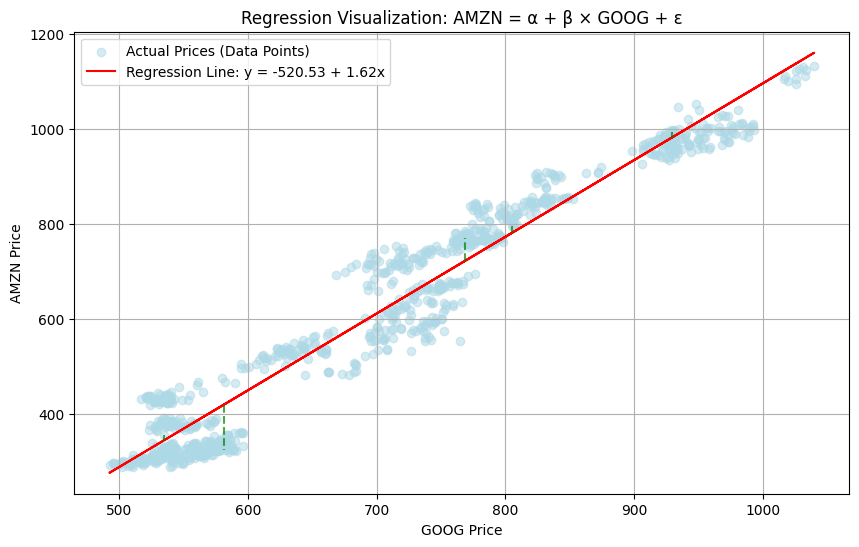

Alpha (α): -520.53
Beta (β): 1.6161
Green dashed lines = residuals (εₜ = Spread)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

# Extract the prices
x = data['GOOG']
y = data['AMZN']

# Run regression again
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha, beta = model.params['const'], model.params['GOOG']

# Predicted AMZN prices (regression line)
y_pred = alpha + beta * x

# Choose a few sample points for illustration
sample_points = np.random.choice(len(x), 5, replace=False)
sample_x = x.iloc[sample_points]
sample_y = y.iloc[sample_points]
sample_y_pred = alpha + beta * sample_x

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Actual Prices (Data Points)', color='lightblue')
plt.plot(x, y_pred, color='red', label=f'Regression Line: y = {alpha:.2f} + {beta:.2f}x')

# Draw epsilon (residuals)
for i in range(len(sample_x)):
    plt.vlines(sample_x.iloc[i], sample_y_pred.iloc[i], sample_y.iloc[i],
                   color='green', linestyle='--', alpha=0.7)

# Labels
plt.title("Regression Visualization: AMZN = α + β × GOOG + ε")
plt.xlabel("GOOG Price")
plt.ylabel("AMZN Price")
plt.legend()
plt.grid(True)
plt.show()

print(f"Alpha (α): {alpha:.2f}")
print(f"Beta (β): {beta:.4f}")
print("Green dashed lines = residuals (εₜ = Spread)")

In [ ]:
z = (spread - spread_mean) / spread_std
entry, exit_ = 2.0, 0.5

signals = pd.DataFrame(index=data.index)
signals['z'] = z
signals['long_entry']  = (signals['z'] < -entry).astype(int)
signals['short_entry'] = (signals['z'] >  entry).astype(int)
signals['exit']        = (signals['z'].abs() < exit_).astype(int)
display(signals.tail())


,z,long_entry,short_entry,exit
Date,,,,
2017-11-06,-0.294862,0,0,1
2017-11-07,-0.462147,0,0,1
2017-11-08,-0.476710,0,0,1
2017-11-09,-0.292269,0,0,1
2017-11-10,-0.274023,0,0,1


In [ ]:
pos = pd.Series(0, index=signals.index, dtype=int)

for t in range(1, len(pos)):
    prev = pos.iloc[t-1]

    if prev == 0:
        if signals['long_entry'].iloc[t]:
            pos.iloc[t] = 1
        elif signals['short_entry'].iloc[t]:
            pos.iloc[t] = -1
        else:
            pos.iloc[t] = 0
    else:
        if signals['exit'].iloc[t]:
            pos.iloc[t] = 0
        else:
            pos.iloc[t] = prev

signals['position'] = pos
display(signals[['z','position']].tail())

,z,position
Date,,
2017-11-06,-0.294862,0
2017-11-07,-0.462147,0
2017-11-08,-0.476710,0
2017-11-09,-0.292269,0
2017-11-10,-0.274023,0


In [ ]:
ret1 = data[stock1].pct_change().fillna(0.0)
ret2 = data[stock2].pct_change().fillna(0.0)

spread_ret = ret1 - beta * ret2
strat_ret  = signals['position'].shift(1).fillna(0) * spread_ret  # enter next day
equity = (1 + strat_ret).cumprod()

print("Last equity value:", float(equity.iloc[-1]))


Last equity value: 1.455553469883896


In [ ]:
def sharpe(returns, freq=252):
    mu = returns.mean() * freq
    sd = returns.std() * (freq**0.5)
    return np.nan if sd == 0 else mu/sd

def max_drawdown(equity_curve):
    roll_max = equity_curve.cummax()
    dd = equity_curve/roll_max - 1.0
    return dd.min()

print("Sharpe (no costs):", sharpe(strat_ret))
print("Max Drawdown:", max_drawdown(equity))
print("Trades taken:", int((signals['position'].diff().abs() == 1).sum()/2))

Sharpe (no costs): 0.6675875615256823
Max Drawdown: -0.24292605027929715
Trades taken: 3


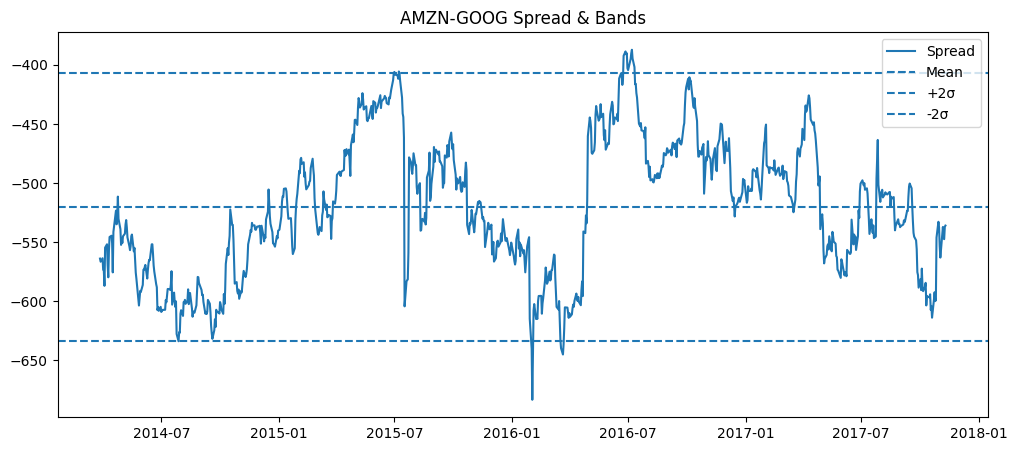

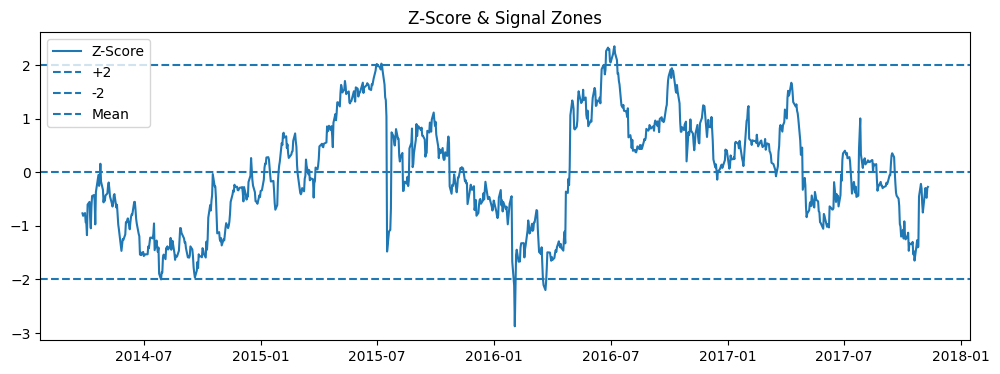

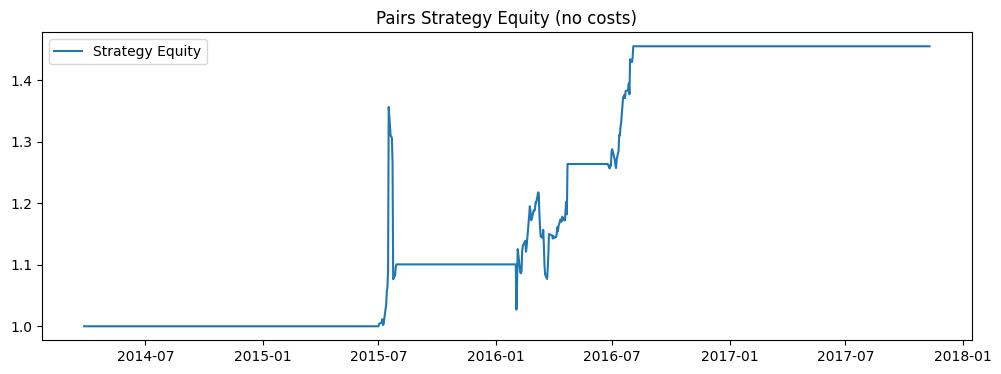

In [ ]:
# Spread with ±2σ
plt.figure(figsize=(12,5))
plt.plot(spread.index, spread, label='Spread')
plt.axhline(spread_mean, linestyle='--', label='Mean')
plt.axhline(spread_mean + 2*spread_std, linestyle='--', label='+2σ')
plt.axhline(spread_mean - 2*spread_std, linestyle='--', label='-2σ')
plt.title(f'{stock1}-{stock2} Spread & Bands')
plt.legend(); plt.show()

# Z-score with entry bands
plt.figure(figsize=(12,4))
plt.plot(signals.index, signals['z'], label='Z-Score')
plt.axhline(2, linestyle='--', label='+2')
plt.axhline(-2, linestyle='--', label='-2')
plt.axhline(0, linestyle='--', label='Mean')
plt.title('Z-Score & Signal Zones')
plt.legend(); plt.show()

# Equity curve
plt.figure(figsize=(12,4))
plt.plot(equity.index, equity, label='Strategy Equity')
plt.title('Pairs Strategy Equity (no costs)')
plt.legend(); plt.show()
